In [1]:
import os
import sys

os.chdir('..')
sys.path.append('src')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, MultiLabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn_genetic import GAFeatureSelectionCV
from sklearn.model_selection import train_test_split
from utilsPlots import na_plot, plot_density, plot_bars, plot_predictive_power, heatmap_01_plot
from utilsStats import cramers_v, univariate_predictive_power
from utilsOptuna import best_trial_scores_ML


In [3]:
random_state = 42
random.seed(42)
np.random.seed(42)

## Objective

This exercise aims to develop a machine learning model to predict prices for new accommodations based on the available data.

## Exploratory data analysis

Data contained 14,780 samples with 89 features. `Price` feature was considered as target.

In line with the goal of this analysis described above in objetive section, only features related to the accommodation's characteristics (amenities, location, etc.) were retained, while all data related to reviews, availability, or pricing were not be considered.

This applies, for example, when a client has a property with specific features and location, and wants to know at what price to offer accommodation.

The dataset contained no duplicates entries, confirmed by checking the unique identifiers features: `ID`, `Scrape ID` and `Name`. An analysis of missing data revealed that 59 features contain NA values. @fig-na shows the features with the highest percentages of missing values. 


In [4]:
airbnb_data = pd.read_csv("data/airbnb-listings-extract.csv", delimiter = ';') 

In [5]:
print(f'Number of samples: {airbnb_data.shape[0]}')
print(f'Number of features: {airbnb_data.shape[1]}')

Number of samples: 14780
Number of features: 89


In [6]:
# check data structure
airbnb_data.head().T

,0,1,2,3,4
ID,11210388,17471131,17584891,5398030,18104606
Listing Url,https://www.airbnb.com/rooms/11210388,https://www.airbnb.com/rooms/17471131,https://www.airbnb.com/rooms/17584891,https://www.airbnb.com/rooms/5398030,https://www.airbnb.com/rooms/18104606
Scrape ID,20170306202425,20170407214050,20170407214050,20170407214050,20170407214050
Last Scraped,2017-03-07,2017-04-08,2017-04-08,2017-04-08,2017-04-08
Name,The Loft-Full Bath-Deck w/View,"Claris I, Friendly Rentals","Style Terrace Red, Friendly Rentals",Picasso Suite 1.4 Paseo de Gracia,Smart City Centre Apartment II
...,...,...,...,...,...
Cancellation Policy,moderate,super_strict_30,super_strict_30,strict,flexible
Calculated host listings count,1.0,106.0,106.0,24.0,92.0
Reviews per Month,3.5,0.86,NaN,1.09,NaN
Geolocation,"30.3373609355,-97.8632766782","41.3896829422,2.17262543017","41.3930345489,2.16217327868","41.3969668101,2.1674178103","41.3886851936,2.15514963616"


In [ ]:
# any duplicated sample?
for feature in ['ID', 'Scrape ID', 'Name']:
    dupl = sum(airbnb_data[feature].duplicated())
    print(f'Number of duplicated {feature}: {dupl}')

Number of duplicated ID: 0
Number of duplicated Scrape ID: 0
Number of duplicated Name: 0


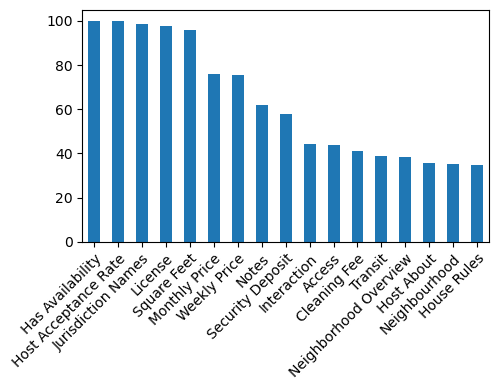

In [8]:
#| output: True
#| label: fig-na
#| fig-cap: "Percentage of missing values by feature (showing features with >30% NA values)"
na_plot(airbnb_data, threshold=30)

In [9]:
print(f'Number of features with NA value: {sum(airbnb_data.isna().sum() > 0)}')
print(f"Number of NA values for Price feature: {airbnb_data['Price'].isna().sum()}")

Number of features with NA value: 59
Number of NA values for Price feature: 17


In [10]:
df_train, df_test = train_test_split(airbnb_data, test_size = 0.3, shuffle = True, random_state = random_state)

### Target feature.

The distribution of the `Price` feature showed a right-skewed to the right with a peak around 50 (@fig-price). Values ranged from 9.0 to 999.0. The target feature contained 17 NA values. This accommodations were removed before training the model and were used later for testing.

In [11]:
df_train['Price'].describe()

count    10336.000000
mean        73.810275
std         73.435714
min          9.000000
25%         34.000000
50%         55.000000
75%         88.000000
max        999.000000
Name: Price, dtype: float64

In [12]:
df_train[df_train['Price'] > 800][['Price', 'Bedrooms','City']]

,Price,Bedrooms,City
10762,828.0,4.0,Paris
5825,999.0,4.0,Malibu
9671,969.0,1.0,Hong Kong
1587,875.0,5.0,Madrid
14768,950.0,5.0,Son Vida
1933,850.0,10.0,Madrid
3385,907.0,1.0,Frederiksberg C


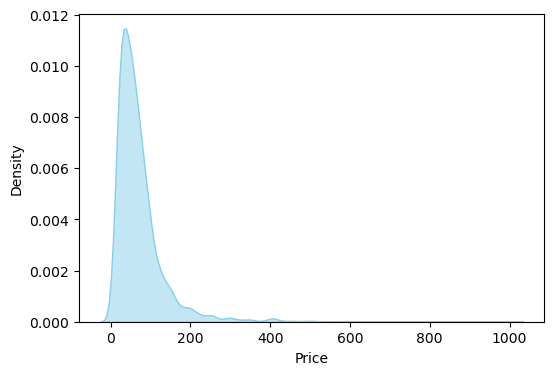

In [13]:
#| output: True
#| label: fig-price
#| fig-cap: "Distribution of the Price feature."
plot_density(df_train, ['Price'], 1, 1)

### Features for prediction.


A selection of features was performed. First, all features with data available for more than 70% of samples were kept (for example, the `Square Feet` feature). Next, features unrelated to accomodation characteristics were also removed, such as those containing strings like **url**, **host** or **name**. After this filtering process, only 25 features remained.

In [14]:
# feature to be dropped (PREPROC)
# variables with more than 70% of their values as NA are discarded 
# there is not enough information for imputation.
features_na_drop = ['Has Availability', 'Host Acceptance Rate', 'Jurisdiction Names', 'License', 'Square Feet', 'Monthly Price', 'Weekly Price']

In [15]:
# numeric/non numeric columns 
df_types = df_train.dtypes
columns_non_num = df_types[df_types == 'object'].index
columns_num = df_types[df_types != 'object'].index
print(f'Number of non-numeric features: {len(columns_non_num)}\n')
print(', '.join(columns_non_num))
print(f'\nNumber of numeric features: {len(columns_num)}\n')
print(', '.join(columns_num))

Number of non-numeric features: 53

Listing Url, Last Scraped, Name, Summary, Space, Description, Experiences Offered, Neighborhood Overview, Notes, Transit, Access, Interaction, House Rules, Thumbnail Url, Medium Url, Picture Url, XL Picture Url, Host URL, Host Name, Host Since, Host Location, Host About, Host Response Time, Host Acceptance Rate, Host Thumbnail Url, Host Picture Url, Host Neighbourhood, Host Verifications, Street, Neighbourhood, Neighbourhood Cleansed, Neighbourhood Group Cleansed, City, State, Zipcode, Market, Smart Location, Country Code, Country, Property Type, Room Type, Bed Type, Amenities, Calendar Updated, Has Availability, Calendar last Scraped, First Review, Last Review, License, Jurisdiction Names, Cancellation Policy, Geolocation, Features

Number of numeric features: 36

ID, Scrape ID, Host ID, Host Response Rate, Host Listings Count, Host Total Listings Count, Latitude, Longitude, Accommodates, Bathrooms, Bedrooms, Beds, Square Feet, Price, Weekly Price, 

In [16]:
# overview non-numeric columns that contain 'url', 'scraped', 'name', 'calendar' or 'host' strings
columns_sel = list(filter(lambda x: any(s in x.lower() for s in ['url', 'scraped', 'name', 'calendar', 'host']), columns_non_num))
print(f'Number of selected columns: {len(columns_sel)}')
df_train[columns_sel].head().T

Number of selected columns: 21


,1584,9780,12615,9558,1975
Listing Url,https://www.airbnb.com/rooms/15606318,https://www.airbnb.com/rooms/13344738,https://www.airbnb.com/rooms/14113692,https://www.airbnb.com/rooms/7022536,https://www.airbnb.com/rooms/4838000
Last Scraped,2017-04-08,2017-04-08,2017-04-08,2017-04-08,2017-04-08
Name,Clean and quiet room in an attic.Close to Bern...,Cozy Apartment Downtown Madrid,Apartamento en Prícipe de Vergara,3 Room Madrid CENTER QUEVEDO,"OLAVIDE XIV, 4ºC, Friendly Rentals"
Thumbnail Url,https://a0.muscache.com/im/pictures/abf04619-8...,https://a0.muscache.com/im/pictures/00becaa5-0...,https://a0.muscache.com/im/pictures/9c577666-2...,https://a0.muscache.com/im/pictures/96334368/5...,NaN
Medium Url,https://a0.muscache.com/im/pictures/abf04619-8...,https://a0.muscache.com/im/pictures/00becaa5-0...,https://a0.muscache.com/im/pictures/9c577666-2...,https://a0.muscache.com/im/pictures/96334368/5...,NaN
Picture Url,https://public.opendatasoft.com/api/v2/catalog...,https://public.opendatasoft.com/api/v2/catalog...,https://public.opendatasoft.com/api/v2/catalog...,https://public.opendatasoft.com/api/v2/catalog...,https://public.opendatasoft.com/api/v2/catalog...
XL Picture Url,https://a0.muscache.com/im/pictures/abf04619-8...,https://a0.muscache.com/im/pictures/00becaa5-0...,https://a0.muscache.com/im/pictures/9c577666-2...,https://a0.muscache.com/im/pictures/96334368/5...,NaN
Host URL,https://www.airbnb.com/users/show/31870759,https://www.airbnb.com/users/show/75608415,https://www.airbnb.com/users/show/84941846,https://www.airbnb.com/users/show/24391073,https://www.airbnb.com/users/show/21514948
Host Name,Pablo,Javier,Leticia,José María,Raquel
Host Since,2015-04-24,2016-06-03,2016-07-20,2014-12-02,2014-09-19


In [17]:
# overview non_numeric columns NOT containing 'url', 'scraped', 'name', 'calendar' or 'host' strings
columns_sel = list(filter(lambda x: not(any(s in x.lower() for s in ['url', 'scraped', 'name', 'calendar', 'host'])), columns_non_num))
print(f'Number of selected columns: {len(columns_sel)}')
df_train[columns_sel].head().T

Number of selected columns: 32


,1584,9780,12615,9558,1975
Summary,Room with a bed (90 x 190 ) in a very bright a...,Very cozy apartment next to Chueca and Gran ví...,"Amplio apartamento con encanto muy luminoso, r...","Flat in the heart of Madrid, next to Plaza de ...",This apartment in an upmarket building will me...
Space,The tranquility of the building and tidiness o...,The apartment is located in one of the most at...,"Amplio apartamento con encanto muy luminoso, r...","Flat in the heart of Madrid, next to Plaza de ...",This lovely apartment is one of several we can...
Description,Room with a bed (90 x 190 ) in a very bright a...,Very cozy apartment next to Chueca and Gran ví...,"Amplio apartamento con encanto muy luminoso, r...","Flat in the heart of Madrid, next to Plaza de ...",This apartment in an upmarket building will me...
Experiences Offered,none,none,none,none,none
Neighborhood Overview,"Central, well connected and with all kinds of ...",NaN,Vuestra casa se encuentra en el distrito de Ch...,Muy tranquilo y a 2 minutos andando de Malasañ...,This apartment in an upmarket building will me...
Notes,"Only serious and responsible people, the house...",NaN,NaN,NaN,NaN
Transit,"Bus: Line 14 direct to Atocha at the door, lin...",Two minute walk to gran via. Five minute walk ...,A cinco minutos de la estación de metro “Aveni...,"It is best to move on foot, because the apartm...","It is calm, quite zone and you don’t have to s..."
Access,The living room has a 43-inch TV with SmartTV ...,The apartment is a third floor and has a lift....,Se ruega respetar el descanso de los vecinos. ...,In the heart of Madrid and accessibility in th...,"Wifi, TV, washing machine, Microwave, full equ..."
Interaction,Total availability to help in any way I can. M...,NaN,NaN,Our intent is your comfort. We will deliver th...,"We are doing the check in at the office, locat..."
House Rules,No se permite fumar ni hacer fiestas o eventos...,No pets allowed. Smoking is not allowed. No se...,NaN,We want to give a comfortable and friendly acc...,Checkin is done at the apartment. Late checkin...


In [18]:
# features to be kept (PREPROC)
# variables are reviewed and an initial filtering of variables with no useful information is performed.
features_non_num_keep = ['Host Location', 'Host Neighbourhood', 'Experiences Offered', 'Neighbourhood', 'Neighbourhood Cleansed', 
                         'Neighbourhood Group Cleansed', 'City', 'State', 'Market', 'Smart Location', 'Country Code', 'Country', 
                         'Property Type', 'Room Type', 'Bed Type', 'Amenities', 'License', 'Cancellation Policy', 'Geolocation']

In [19]:
# overview numeric columns
print(f'Number of selected columns: {len(columns_num)}')
df_train[columns_num].head().T

Number of selected columns: 36


,1584,9780,12615,9558,1975
ID,1.560632e+07,1.334474e+07,1.411369e+07,7.022536e+06,4.838000e+06
Scrape ID,2.017041e+13,2.017041e+13,2.017041e+13,2.017041e+13,2.017041e+13
Host ID,3.187076e+07,7.560842e+07,8.494185e+07,2.439107e+07,2.151495e+07
Host Response Rate,1.000000e+02,1.000000e+02,8.800000e+01,9.600000e+01,7.500000e+01
Host Listings Count,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.640000e+02
Host Total Listings Count,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.640000e+02
Latitude,4.045434e+01,4.042213e+01,4.043860e+01,4.043084e+01,4.043419e+01
Longitude,-3.681293e+00,-3.700504e+00,-3.678499e+00,-3.701177e+00,-3.702951e+00
Accommodates,1.000000e+00,2.000000e+00,4.000000e+00,4.000000e+00,6.000000e+00
Bathrooms,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00


In [20]:
# features to be dropped 
# not have relevant information for a new accommodation that it is going to be offered for the first time
features_num_drop = ['ID', 'Scrape ID', 'Host ID', 'Host Response Rate', 'Host Listings Count', 'Host Total Listings Count', 
                     'Geolocation', 'Weekly Price', 'Monthly Price', 'Security Deposit', 
                     'Cleaning Fee','Extra People','Minimum Nights', 'Maximum Nights', 'Availability 30', 'Availability 60', 'Availability 90', 
                     'Availability 365', 'Number of Reviews', 'Review Scores Rating', 'Review Scores Accuracy', 'Review Scores Cleanliness', 
                     'Review Scores Checkin', 'Review Scores Communication', 'Review Scores Location', 'Review Scores Value', 
                     'Calculated host listings count', 'Reviews per Month']

In [21]:
# result from first filtering step (PREPROC)
features_non_num_drop = [feature for feature in columns_non_num if not(feature in features_non_num_keep)]
features_clean1_drop = features_non_num_drop + features_num_drop + features_na_drop
df_train_clean = df_train.drop(features_clean1_drop, axis = 1)
print(f'Number of features: {df_train_clean.shape[1]}\n')
print(', '.join(df_train_clean.columns.tolist()))

Number of features: 25

Experiences Offered, Host Location, Host Neighbourhood, Neighbourhood, Neighbourhood Cleansed, Neighbourhood Group Cleansed, City, State, Market, Smart Location, Country Code, Country, Latitude, Longitude, Property Type, Room Type, Accommodates, Bathrooms, Bedrooms, Beds, Bed Type, Amenities, Price, Guests Included, Cancellation Policy


In [22]:
df_train_clean.head().T

,1584,9780,12615,9558,1975
Experiences Offered,none,none,none,none,none
Host Location,Spain,ES,"Madrid, Community of Madrid, Spain","Madrid, Community of Madrid, Spain","Madrid, Community of Madrid, Spain"
Host Neighbourhood,NaN,NaN,Prosperidad,Palacio,Rios Rosas
Neighbourhood,NaN,NaN,Prosperidad,NaN,Trafalgar
Neighbourhood Cleansed,Hispanoamérica,Justicia,Prosperidad,Trafalgar,Trafalgar
Neighbourhood Group Cleansed,Chamartín,Centro,Chamartín,Chamberí,Chamberí
City,Madrid,Madrid,Madrid,Madrid,Madrid
State,Comunidad de Madrid,Comunidad de Madrid,Comunidad de Madrid,Comunidad de Madrid,Comunidad de Madrid
Market,Madrid,Madrid,Madrid,Madrid,Madrid
Smart Location,"Madrid, Spain","Madrid, Spain","Madrid, Spain","Madrid, Spain","Madrid, Spain"


In the second stage, the remaining features were examined in greater detail to identify redundancies. For example, multiple location-related features were available (`Host Location`, `City`, `State`,`Market`, `Smart Location`, `Country Code`, `Country`). These variables contained highly redundant information, so only the most informative ones were retained (`Smart Location` and `Country Code`).

In [23]:
# features related to location
features_location = ['Host Location', 'City', 'State','Market', 'Smart Location', 'Country Code', 'Country']
df_train_clean[features_location]

,Host Location,City,State,Market,Smart Location,Country Code,Country
1584,Spain,Madrid,Comunidad de Madrid,Madrid,"Madrid, Spain",ES,Spain
9780,ES,Madrid,Comunidad de Madrid,Madrid,"Madrid, Spain",ES,Spain
12615,"Madrid, Community of Madrid, Spain",Madrid,Comunidad de Madrid,Madrid,"Madrid, Spain",ES,Spain
9558,"Madrid, Community of Madrid, Spain",Madrid,Comunidad de Madrid,Madrid,"Madrid, Spain",ES,Spain
1975,"Madrid, Community of Madrid, Spain",Madrid,Comunidad de Madrid,Madrid,"Madrid, Spain",ES,Spain
...,...,...,...,...,...,...,...
5191,"Madrid, Community of Madrid, Spain",Madrid,Comunidad de Madrid,Madrid,"Madrid, Spain",ES,Spain
13418,Spain,Madrid,Comunidad de Madrid,Madrid,"Madrid, Spain",ES,Spain
5390,US,Madrid,Comunidad de Madrid,Madrid,"Madrid, Spain",ES,Spain
860,"Madrid, Community of Madrid, Spain",Madrid,Comunidad de Madrid,Madrid,"Madrid, Spain",ES,Spain


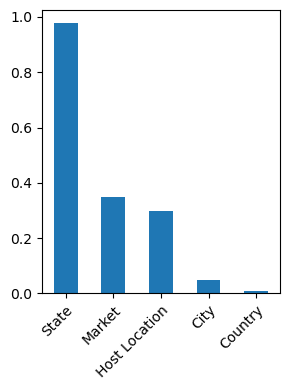

In [24]:
# plot NA for these features
na_plot(df_train_clean[features_location], threshold=0)

In [25]:
print(f'Number of levels: {df_train_clean["Smart Location"].value_counts().shape[0]}')
df_train_clean['Smart Location'].value_counts().head(8)

Number of levels: 205


Smart Location
Madrid, Spain             9243
Barcelona, Spain           202
London, United Kingdom      92
Paris, France               73
Palma, Spain                37
马德里, Spain                  36
Berlin, Germany             29
New York, NY                28
Name: count, dtype: int64

In [26]:
print(f'Number of levels: {df_train_clean["Country Code"].value_counts().shape[0]}')
df_train_clean['Country Code'].value_counts().head(8)

Number of levels: 18


Country Code
ES    9805
US     134
GB     114
FR      73
IT      48
AU      32
DE      30
IE      27
Name: count, dtype: int64

In [27]:
# features to be dropped (PREPROC)
features_location_drop = ['Host Location', 'City', 'State','Market', 'Country']

A similar situation occured with neighborhood-related features. In this case, only 'Neighbourhood Group Cleaned' was retained because it contained no missing values and served as a simplified version of 'Neighbourhood Cleaned' with fewer categorical levels.

In [28]:
# features related to neighbourhood
df_train_madrid = df_train_clean[df_train_clean['Smart Location'] == 'Madrid, Spain']
df_train_madrid['Neighb. G. Clean'] = df_train_madrid['Neighbourhood Group Cleansed']
df_train_madrid['Neighb. Clean'] = df_train_madrid['Neighbourhood Cleansed']
df_train_madrid['Neighb.'] = df_train_madrid['Neighbourhood']
df_train_madrid['Host Neighb.'] = df_train_madrid['Host Neighbourhood']
features_neighbour = ['Host Neighb.', 'Neighb.', 'Neighb. Clean', 'Neighb. G. Clean']
df_train_madrid[features_neighbour]

/tmp/ipykernel_250762/2614993935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_madrid['Neighb. G. Clean'] = df_train_madrid['Neighbourhood Group Cleansed']
/tmp/ipykernel_250762/2614993935.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_madrid['Neighb. Clean'] = df_train_madrid['Neighbourhood Cleansed']
/tmp/ipykernel_250762/2614993935.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

,Host Neighb.,Neighb.,Neighb. Clean,Neighb. G. Clean
1584,NaN,NaN,Hispanoamérica,Chamartín
9780,NaN,NaN,Justicia,Centro
12615,Prosperidad,Prosperidad,Prosperidad,Chamartín
9558,Palacio,NaN,Trafalgar,Chamberí
1975,Rios Rosas,Trafalgar,Trafalgar,Chamberí
...,...,...,...,...
5191,NaN,NaN,Ciudad Jardín,Chamartín
13418,NaN,NaN,Puerta del Angel,Latina
5390,NaN,NaN,Universidad,Centro
860,Embajadores,Embajadores,Embajadores,Centro


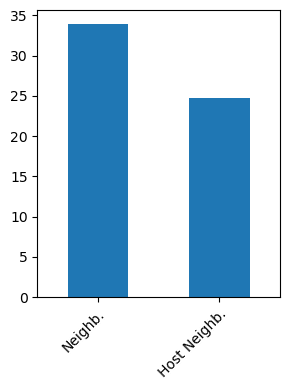

In [29]:
# plot NA for these features
na_plot(df_train_madrid[features_neighbour], threshold=0)

In [30]:
print(f'Number of levels: {df_train_madrid["Neighbourhood Cleansed"].value_counts().shape[0]}')
df_train_madrid['Neighbourhood Cleansed'].value_counts()

Number of levels: 124


Neighbourhood Cleansed
Embajadores       1286
Universidad        955
Palacio            757
Sol                675
Justicia           553
                  ... 
Amposta              3
Fuentelareina        2
Cuatro Vientos       2
Santa Eugenia        1
Orcasitas            1
Name: count, Length: 124, dtype: int64

In [31]:
print(f'Number of levels: {df_train_madrid["Neighbourhood Group Cleansed"].value_counts().shape[0]}')
df_train_madrid['Neighbourhood Group Cleansed'].value_counts()

Number of levels: 21


Neighbourhood Group Cleansed
Centro                   4730
Chamberí                  655
Salamanca                 624
Arganzuela                574
Tetuán                    309
Retiro                    290
Moncloa - Aravaca         277
Carabanchel               261
Latina                    261
Chamartín                 256
Ciudad Lineal             220
Puente de Vallecas        163
Hortaleza                 118
Fuencarral - El Pardo     115
Usera                     106
San Blas - Canillejas      73
Villaverde                 58
Moratalaz                  57
Barajas                    53
Villa de Vallecas          27
Vicálvaro                  16
Name: count, dtype: int64

In [32]:
features_neighbour_drop = ['Host Neighbourhood', 'Neighbourhood', 'Neighbourhood Cleansed']

`Experiences Offered` feature was discarded because information was only available for 11 samples.


In [33]:
# experiences Offered feature
df_train_clean['Experiences Offered'].value_counts()

Experiences Offered
none        10338
business        5
romantic        2
social          1
Name: count, dtype: int64

In [34]:
# remove features (PREPROC)
features_clean2_drop = features_location_drop + features_neighbour_drop + ['Experiences Offered']
df_train_clean2 = df_train_clean.drop(features_clean2_drop, axis = 1)
df_train_clean2['Neighbour'] = df_train_clean2['Neighbourhood Group Cleansed']
df_train_clean2 = df_train_clean2.drop(['Neighbourhood Group Cleansed'], axis = 1)
print(f'Number of features: {df_train_clean2.shape[1]}\n')
print(list(df_train_clean2.columns))
df_train_clean2.head().T

Number of features: 16

['Smart Location', 'Country Code', 'Latitude', 'Longitude', 'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type', 'Amenities', 'Price', 'Guests Included', 'Cancellation Policy', 'Neighbour']


,1584,9780,12615,9558,1975
Smart Location,"Madrid, Spain","Madrid, Spain","Madrid, Spain","Madrid, Spain","Madrid, Spain"
Country Code,ES,ES,ES,ES,ES
Latitude,40.454337,40.42213,40.438604,40.430845,40.434191
Longitude,-3.681293,-3.700504,-3.678499,-3.701177,-3.702951
Property Type,House,Apartment,Apartment,Apartment,Apartment
Room Type,Private room,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt
Accommodates,1,2,4,4,6
Bathrooms,1.0,1.0,1.0,1.0,2.0
Bedrooms,1.0,0.0,1.0,3.0,2.0
Beds,1.0,1.0,2.0,3.0,4.0


After this filtering process, 16 features were retained. A comprehensive analysis of these remaining features is presented below. Visual inspection was conducted by grouping features into types: discrete quantitative, qualitative and continuous quantitative. `Amenities`, `Smart Location` and `Neighbourhood` features were analysed separately.

In [35]:
features_class = {'qualitative': ['Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy', 'Country Code'],
            'discreteQuantitative': ['Accommodates', 'Bedrooms', 'Beds', 'Guests Included'],
            'contQuantitative': ['Latitude', 'Longitude', 'Bathrooms']}

**Discrete quantitative**

These features showed different distributions with most of the accomodations having one bathroom, one bedroom, one bed and accomodating one guest (see @fig-features-discquan). One accomodation showed a zero value for the `Guest included` feature and 66 accomodations showed zero value for the `Bathrooms` feature.

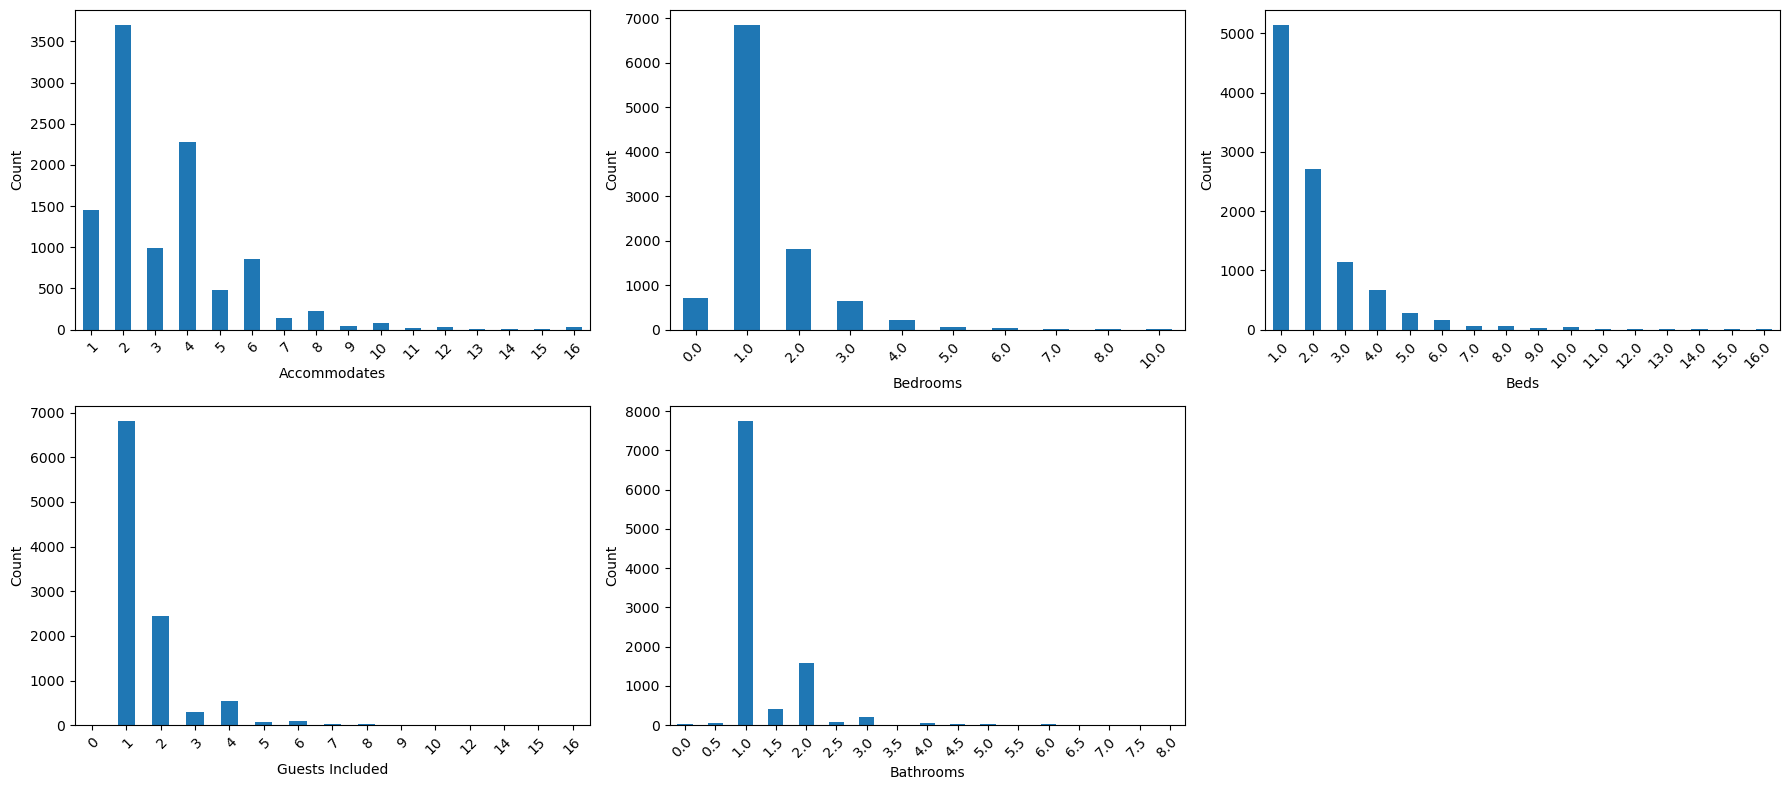

In [36]:
#| output: True
#| label: fig-features-discquan
#| fig-cap: "Distribution for discrete quantitative features."
plot_bars(df_train_clean2, features_class['discreteQuantitative'] + ['Bathrooms'], 2, 3, sort = False)

In [37]:
guest_included_zero = sum(df_train_clean2['Guests Included'] == 0)
print(f'Number of samples with zero in feature Guest Included: {guest_included_zero}')
df_train_clean2[df_train_clean2['Guests Included'] == 0]

Number of samples with zero in feature Guest Included: 1


,Smart Location,Country Code,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Price,Guests Included,Cancellation Policy,Neighbour
2905,"Manchester, United Kingdom",GB,53.451453,-2.26542,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"Internet,Wireless Internet,Kitchen,Free Parkin...",30.0,0,moderate,NaN


In [38]:
bathrooms_zero = sum(df_train_clean2['Bathrooms'] == 0)
print(f'Number of samples with zero in feature Bathrooms: {bathrooms_zero}')
df_train_clean2[df_train_clean2['Bathrooms'] == 0].head()

Number of samples with zero in feature Bathrooms: 41


,Smart Location,Country Code,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Price,Guests Included,Cancellation Policy,Neighbour
4691,"Madrid, Spain",ES,40.419912,-3.705551,Apartment,Private room,2,0.0,1.0,1.0,Real Bed,"TV,Internet,Wireless Internet,Kitchen,Elevator...",30.0,1,flexible,Centro
5318,"Madrid, Spain",ES,40.428877,-3.721406,House,Private room,2,0.0,1.0,2.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Smoking...",39.0,1,flexible,Moncloa - Aravaca
10303,"Madrid, Spain",ES,40.430254,-3.720183,House,Private room,1,0.0,1.0,1.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Smoking...",29.0,1,flexible,Moncloa - Aravaca
11624,"Madrid, Spain",ES,40.387621,-3.727724,Bed & Breakfast,Private room,1,0.0,1.0,2.0,Real Bed,"TV,Wireless Internet,Kitchen,Heating,Washer,Es...",18.0,1,strict,Carabanchel
7100,"Lewisham, Australia",AU,-33.895444,151.144800,House,Private room,2,0.0,1.0,1.0,Real Bed,"Internet,Wireless Internet,Air conditioning,Ki...",66.0,1,flexible,NaN


**Qualitative**

Features exhibited unbalanced distributions across their levels. Most features showed distributions where the majority of samples were concentrated in one or few categories. For example, 'Apartment' was the most frequent level for `Property Type` feature, and most accomodations were labeled 'ES' for the `Country Code` feature (see @fig-features-qual)

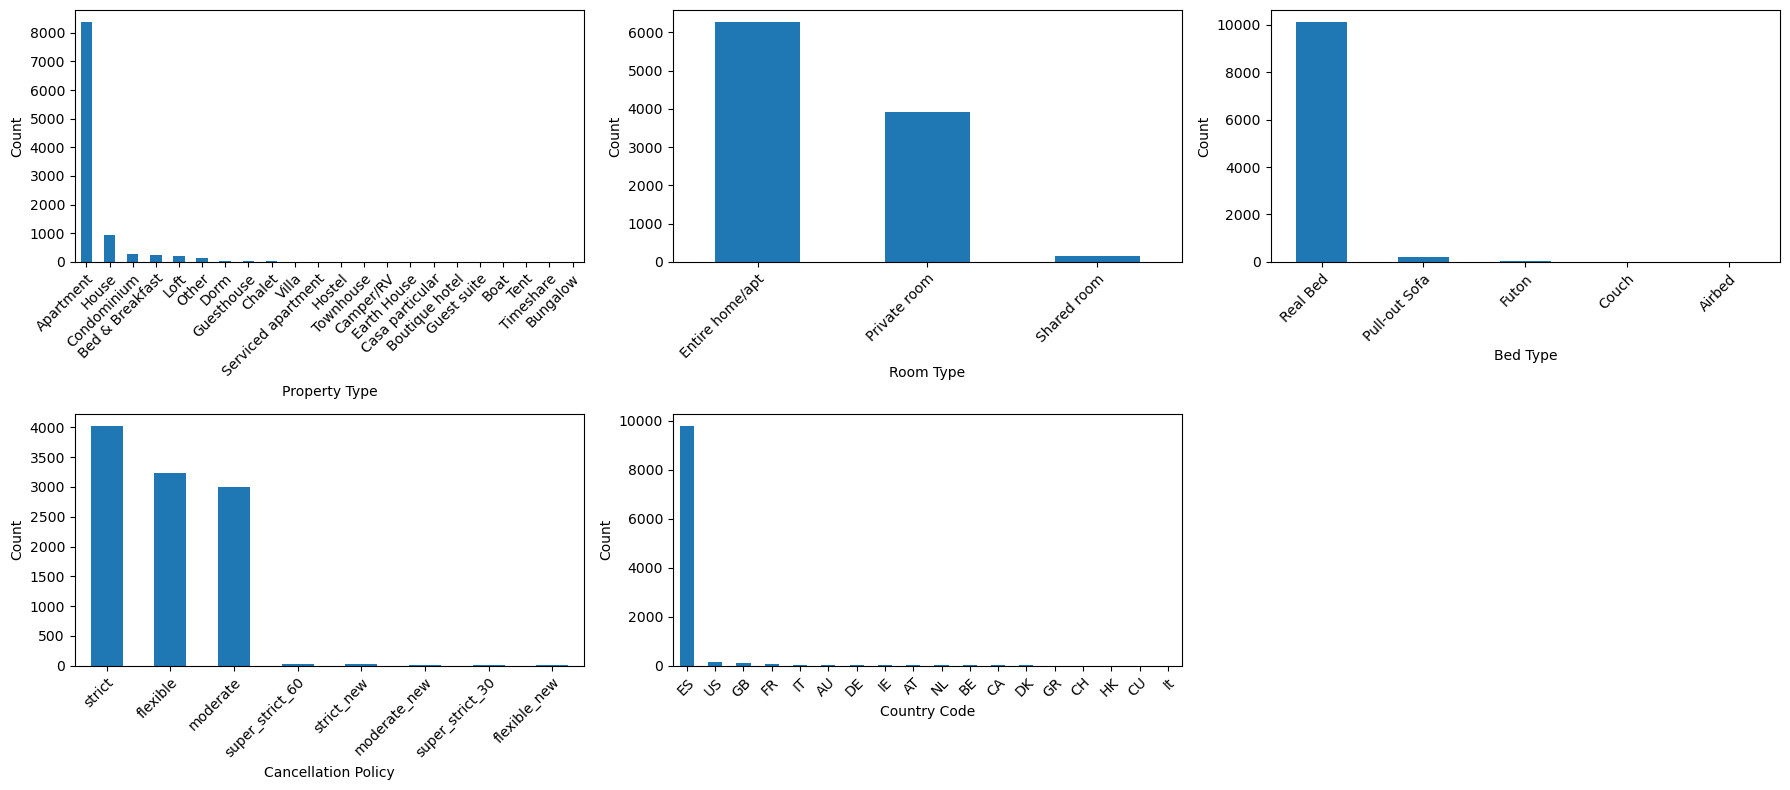

In [39]:
#| output: True
#| label: fig-features-qual
#| fig-cap: "Distribution for qualitative features."
plot_bars(df_train_clean2, features_class['qualitative'], 2, 3, sort = True)

**Continuous quantitative**

These features exhibited sharp peaks centered at 40 and 0 for `Latitude` and `Longitude` respectively (see @fig-features-contquant). The `Latitude` feature ranged from -40 to 60, while `Longitude` from -150 to 150.

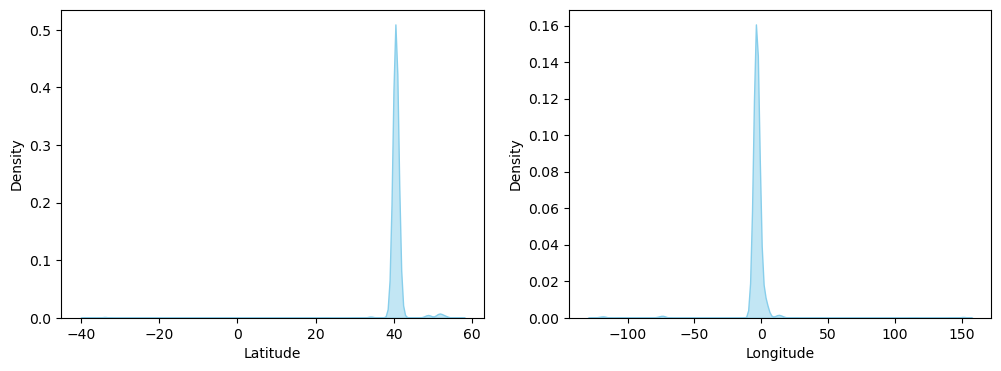

In [40]:
#| output: True
#| label: fig-features-contquant
#| fig-cap: "Distribution for continuous quantitative features."
features = features_class['contQuantitative'].copy()
features.remove('Bathrooms')
plot_density(df_train_clean2, features, 1, 2)

**Amenities feature**

A total of 83 different amenities were found, with only 19 of them included in more than 20% of the accommodations (@fig-amenities)

In [41]:
amenities = pd.Series(sum(df_train_clean2['Amenities'].dropna().str.lower().str.split(',').tolist(), [])).value_counts()
amenities_drop = list(filter(lambda x: 'translation' in x, amenities.index))
print('Amenities to remove:')
print(amenities_drop)
amenities = amenities[list(map(lambda x: 'translation' not in x, amenities.index))]
amenities = amenities/df_train_clean2.shape[0] * 100
print(f'Number of unique amenities: {len(amenities)}')
amenities20 = amenities[amenities > 20]
print(f'Number of amenities > 20%: {len(amenities20)}')

Amenities to remove:
['translation missing: en.hosting_amenity_50', 'translation missing: en.hosting_amenity_49']
Number of unique amenities: 83
Number of amenities > 20%: 19


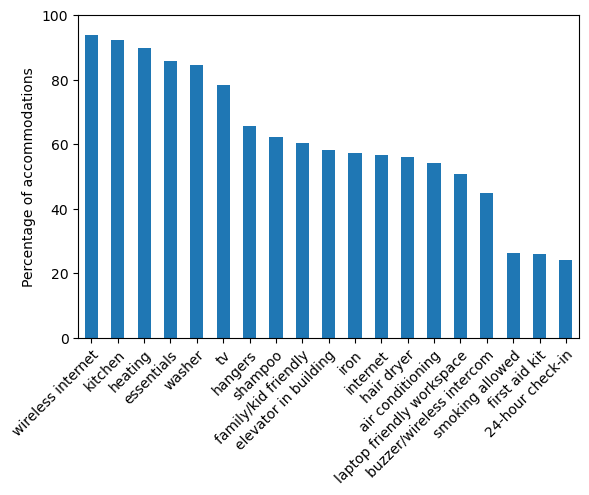

In [42]:
#| output: True
#| label: fig-amenities
#| fig-cap: "Frequencies for the most common amenities (greater than 20%)"
plt.figure(figsize=(6,5))
ax = amenities20.sort_values(ascending=False).plot.bar()
ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation=45,
                   ha='right',  # Horizontal alignment
                   rotation_mode='anchor')
plt.ylabel('Percentage of accommodations')
plt.tight_layout()
plt.ylim(0,100)
plt.show()

**Smart Location**

There were 254 different locations, with most accommodations concentrated in Madrid (over 85%). Barcelona was the second most frequent location, while all others individually accounted for less than 1% each (@fig-location).

In [43]:
slocation = pd.Series(df_train_clean2['Smart Location'].dropna().str.lower().tolist()).value_counts()
slocation = slocation/df_train_clean2.shape[0] * 100
print(f'Number of unique amenities: {len(slocation)}')
slocation.head(5)
slocation5 = slocation[:6]
print(slocation5)

Number of unique amenities: 203
madrid, spain             89.396868
barcelona, spain           1.952445
london, united kingdom     0.889233
paris, france              0.705587
palma, spain               0.357626
马德里, spain                 0.347961
Name: count, dtype: float64


/tmp/ipykernel_250762/1242238152.py:11: UserWarning: Glyph 39532 (\N{CJK UNIFIED IDEOGRAPH-9A6C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_250762/1242238152.py:11: UserWarning: Glyph 24503 (\N{CJK UNIFIED IDEOGRAPH-5FB7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_250762/1242238152.py:11: UserWarning: Glyph 37324 (\N{CJK UNIFIED IDEOGRAPH-91CC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/mapardo/miniconda3/envs/exerciseML/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39532 (\N{CJK UNIFIED IDEOGRAPH-9A6C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mapardo/miniconda3/envs/exerciseML/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24503 (\N{CJK UNIFIED IDEOGRAPH-5FB7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mapardo/miniconda3/envs/exerciseML/lib/python3.10/site-packages

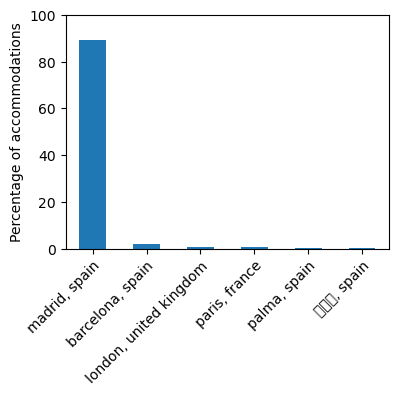

In [44]:
#| output: True
#| label: fig-location
#| fig-cap: "Frequencies for the five most common locations"
plt.figure(figsize=(4,4))
ax = slocation5.sort_values(ascending=False).plot.bar()
ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation=45,
                   ha='right',  # Horizontal alignment
                   rotation_mode='anchor')
plt.ylabel('Percentage of accommodations')
plt.tight_layout()
plt.ylim(0,100)
plt.show()

In [45]:
total_locations = len(set(df_train_clean2['Smart Location'].tolist()))
locations_more_two = sum(df_train_clean2['Smart Location'].value_counts() > 5)
print(f'Number of unique locations: {total_locations}')
print(f'Number of locations with more than two samples: {locations_more_two}')

Number of unique locations: 205
Number of locations with more than two samples: 35


**Neighbourhood**

There were 49 different neighbourhoods, with most accommodations concentrated in Centro (over 45%). All others individually accounted for less than 7% each (@fig-neighb).

In [46]:
neighb = pd.Series(df_train_clean2['Neighbour'].dropna().str.lower().tolist()).value_counts()
neighb = neighb/df_train_clean2.shape[0] * 100
print(f'Number of unique neighbourhood: {len(neighb)}')
neighb10 = neighb[:10]
print(neighb10)

Number of unique neighbourhood: 47
centro               45.872801
chamberí              6.350280
salamanca             6.050648
arganzuela            5.596366
tetuán                3.034989
moncloa - aravaca     2.919003
retiro                2.812681
carabanchel           2.571042
latina                2.542045
chamartín             2.532380
Name: count, dtype: float64


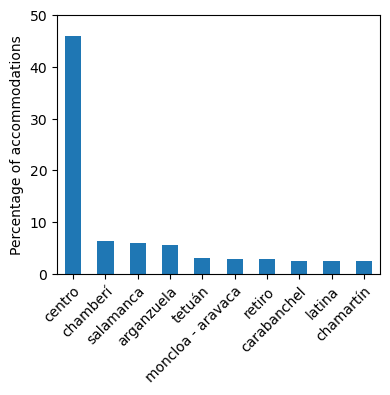

In [47]:
#| output: True
#| label: fig-neighb
#| fig-cap: "Frequencies for the five most common locations"
plt.figure(figsize=(4,4))
ax = neighb10.sort_values(ascending=False).plot.bar()
ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation=45,
                   ha='right',  # Horizontal alignment
                   rotation_mode='anchor')
plt.ylabel('Percentage of accommodations')
plt.tight_layout()
plt.ylim(0,50)
plt.show()

### Feature selection

At this stage, useful features had been selected by discarding those without valuable information. These retained features were used to identify the optimal subset of features with maximum predictive power through a three-steps process:

1. Impute missing values and encode the features to ensure proper processing and compatibility with analytical algorithm.

2. Calculate the individual predictive power of each feature. Features with low predictive power may be discarded.

3. Search for the optimal feature subset to be used in model training.

The imputation strategy was designed based on the distribution of missing values (see @fig-na-feature). Missing values were replaced by the mode (most frequent value).

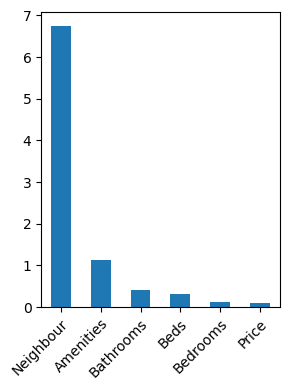

In [48]:
#| output: True
#| label: fig-na-feature
#| fig-cap: "Percentage of missing values"
# features with NA values
na_plot(df_train_clean2, threshold=0)

In [49]:
# NA handling 
# Remove samples without info about Price
df_train_imp = df_train_clean2[~(df_train_clean2['Price'].isna())].copy()
# impute na values in Bedrooms
bedrooms_mode = df_train_clean2['Bedrooms'].mode()[0]
df_train_imp['Bedrooms'] = df_train_imp['Bedrooms'].fillna(bedrooms_mode)
# impute na values in Bathrooms
bathrooms_mode = df_train_clean2['Bathrooms'].mode()[0]
df_train_imp['Bathrooms'] = df_train_imp['Bathrooms'].fillna(bathrooms_mode)
# impute Beds with value from Bedrooms
df_train_imp['Beds'] = df_train_imp['Beds'].fillna(df_train_imp['Bedrooms'])
# impute na values in Amenities
df_train_imp['Amenities'] = df_train_imp['Amenities'].fillna('No services')
# impute zero values in Guests Included by Beds
df_train_imp['Guests Included'] = df_train_imp['Guests Included'].where(df_train_imp['Guests Included'] != 0, df_train_imp['Beds'])
# impute na values in Neighbour
neighbour_mode = df_train_clean2['Neighbour'].mode()[0]
df_train_imp['Neighbour'] = df_train_imp['Neighbour'].fillna(neighbour_mode)

In [50]:
# normalize text features
df_train_imp['Smart Location'] = df_train_imp['Smart Location'].str.lower()
df_train_imp['Neighbour'] = df_train_imp['Neighbour'].str.lower()
df_train_imp['Amenities'] = df_train_imp['Amenities'].str.lower()

In [51]:
# target encoding
df_train_enc = df_train_imp.copy()
qualit_TE = ['Property Type','Room Type', 'Bed Type', 'Cancellation Policy']
qualit_TE_new = list(map(lambda x: x + ' TE', qualit_TE))
X = df_train_enc[qualit_TE].values
y = df_train_enc['Price']

encoder = TargetEncoder(target_type="continuous", smooth = "auto")
encoder.fit(X, y)
df_train_enc[qualit_TE_new] = encoder.transform(X)

# one-hot encoding
qualit_OHE = ['Bed Type', 'Property Type', 'Room Type', 'Cancellation Policy', 'Country Code', 'Smart Location', 'Neighbour']
categories_OHE = [['Real Bed'], ['Apartment', 'House'], ['Entire', 'Private'], ['Flexible', 'Moderate', 'Strict'], ['ES'], ['madrid, spain'], ['centro']]
X = df_train_enc[qualit_OHE]
encoder = OneHotEncoder(sparse_output=False, categories=categories_OHE, handle_unknown = 'ignore')
encoder.fit(X)
X_encoded = encoder.transform(X)

qualit_OHE_new = encoder.get_feature_names_out(input_features=X.columns)

X_encoded_df = pd.DataFrame(X_encoded, columns=qualit_OHE_new).reset_index(drop=True)
X_encoded_df.index = df_train_imp.index
df_train_enc2 = pd.concat([df_train_enc, X_encoded_df], axis=1)

# multi label binarizer amenities
df_train_enc2['AmenitiesStr'] = df_train_enc2['Amenities'].str.lower().str.split(',').tolist()
# remove amenities_drop from list of AmenitiesStr
df_train_enc2['AmenitiesStr'] = df_train_enc2['AmenitiesStr'].apply(lambda x: [amenity for amenity in x if amenity not in amenities_drop])

# Initialize and fit the encoder
mlb = MultiLabelBinarizer()
mlb.fit(df_train_enc2['AmenitiesStr'])
encoded = mlb.transform(df_train_enc2['AmenitiesStr'])
amenities = mlb.classes_

# Convert to DataFrame with proper column names
df_amenities = pd.DataFrame(encoded, columns=mlb.classes_)
df_amenities.index = df_train_imp.index

# Normalization
cols_to_norm = qualit_TE_new + features_class['contQuantitative']
scaler = StandardScaler()
scaler.fit(df_train_enc2[cols_to_norm])
df_train_enc2[cols_to_norm] = scaler.transform(df_train_enc2[cols_to_norm])


The list of amenities were transformed into binary columns. Predictive power analysis was then performed on these amenities to select the most informative (see @fig-mi-amenities). The twelve most informative amenities were selected.

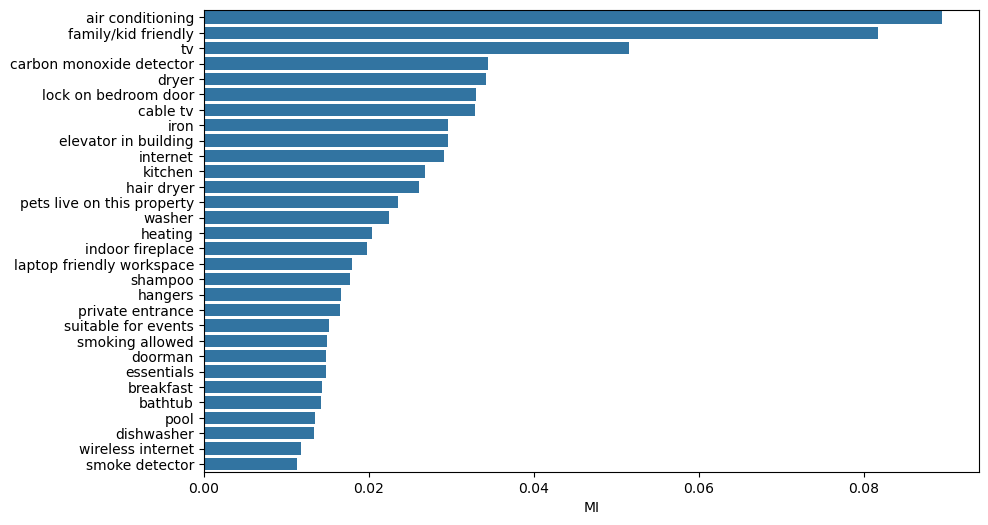

In [52]:
#| output: True
#| label: fig-mi-amenities
#| fig-cap: "Mutual information of amenities features"
# plot mutual information for amenities (most predictive power)
X = df_amenities
y = df_train_imp['Price']
mi_scores = mutual_info_regression(X, y).tolist()
df_mi = pd.DataFrame({'Feature': X.columns, 'Score': mi_scores}).sort_values('Score', ascending = False)
plot_predictive_power(df_mi, 'MI', 30)

In [53]:
# top 12 amenities are selected
amenities_selection = df_mi[:12]['Feature']
df_train_enc3 = pd.concat([df_train_enc2,df_amenities[amenities_selection]], axis=1)
df_train_enc3 = df_train_enc3.drop(set(qualit_TE + qualit_OHE + ['Amenities', 'AmenitiesStr'] + ['Price']), axis=1)

#### Predictive power of each feature

Several parameters were monitorized to evaluate the predictive power of each feature:

- Mutual information between each feature and the target (@fig-mi-features)

- Performance of the 1D model for each feature (@fig-1dmodel-features)

- Relationships between the predictive features using Pearson's correlation, Cramer's V test and mutual information (@fig-features-corr, @fig-features-cramer and @fig-matrix-mi)

Based on this information, some features were removed:

- Although they showed good predictive power, the features `Beds`, `Bedrooms` and `Room Type` were removed because they have a strong relationship with `Accommodates`(@fig-matrix-mi)

- The features `Longitude`, `Smart Location_madrid, spain` and `Neighbour_centro` had a strong relationship according to @fig-matrix-mi. Aditionally, `Smart Location_madrid, spain` and `Country Code_ES` presented moderate correlation (@fig-features-cramer). Since `Longitude` and `Latitude` showed high mutual information with the target, these two features were kept and the others removed.

- The one-hot enconded features derived `Property Type` were removed due to their strong relationship with the target-encoded version of `Property Type` (@fig-matrix-mi). The target-encoded feature was kept because it showed a high relationship with target.

- The same approach was applied to the `Bed Type` features. Although both the encoded features showed moderate relationships, the one-hot encoded version presented a higher mutual information with target, so it was kept (@fig-mi-features).

- The one-hot encoded `Cancellation Policy` features have very low predicitive power so were removed (@fig-mi-features and @fig-1dmodel-features).

Finally, twenty features were kept to perform the step of searching for the optimal subset of features.


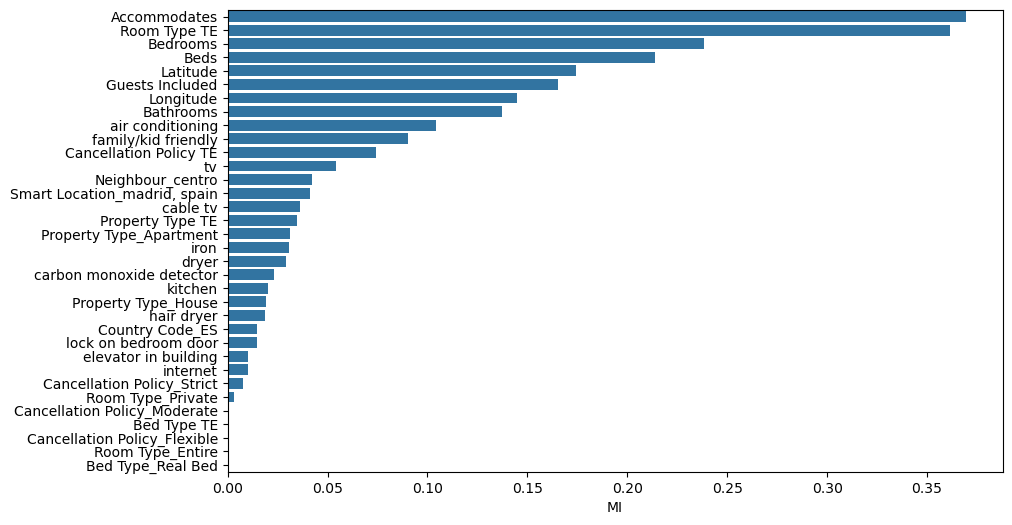

In [54]:
#| output: True
#| label: fig-mi-features
#| fig-cap: "Mutual information of features"
# plot mutual information for features (most predictive power)
X = df_train_enc3
y = df_train_imp['Price']
mi_scores = mutual_info_regression(X, y).tolist()
df_mi = pd.DataFrame({'Feature': X.columns, 'Score': mi_scores}).sort_values('Score', ascending = False)
plot_predictive_power(df_mi, 'MI')

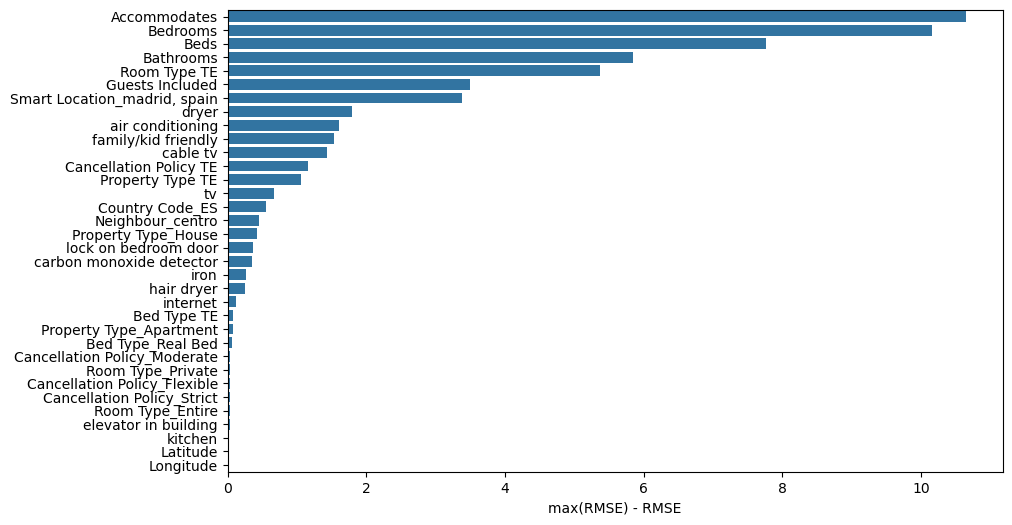

In [55]:
#| output: True
#| label: fig-1dmodel-features
#| fig-cap: "RMSE difference relative to worst 1D model"
X = df_train_enc3
y = df_train_imp['Price']
model = LinearRegression()

univariate_scores = univariate_predictive_power(X, y, model=model)

univariate_scores['Score'] = -1*(univariate_scores['Score'] - max(univariate_scores['Score']))

plot_predictive_power(univariate_scores, 'max(RMSE) - RMSE')

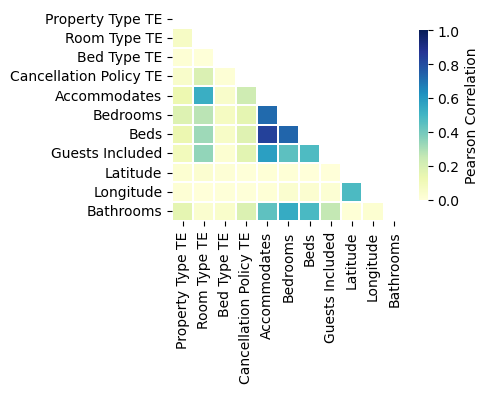

In [56]:
#| output: True
#| label: fig-features-corr
#| fig-cap: "Pearson correlation between features"
# numerical features
features_sel = qualit_TE_new + features_class['discreteQuantitative'] + features_class['contQuantitative']

# Compute the correlation matrix
corr = np.abs(df_train_enc3[features_sel].corr())

heatmap_01_plot(corr, triangle = True, label = "Pearson Correlation")

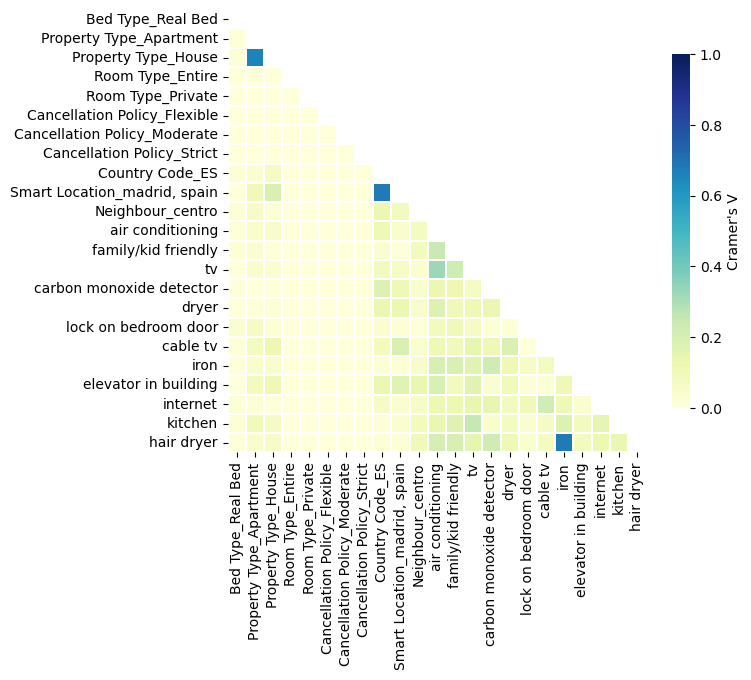

In [57]:
#| output: True
#| label: fig-features-cramer
#| fig-cap: "Cramer's V for categorical features"
# relationship between categorical features (Cramer's V test)
features_sel = qualit_OHE_new.tolist() + amenities_selection.to_list()

scores = []
for feature1 in features_sel:
    score_feature = []
    for feature2 in features_sel:
        score_feature.append(cramers_v(df_train_enc3[feature1], df_train_enc3[feature2]))
    scores.append(score_feature)

cramer = pd.DataFrame(scores, columns = features_sel, index = features_sel)

heatmap_01_plot(cramer, triangle = True, label = "Cramer's V")

In [58]:
# build MI matrix
features_classif = qualit_OHE_new.tolist() + amenities_selection.to_list() + features_class['discreteQuantitative']
features_regression = qualit_TE_new + features_class['contQuantitative']

scores = {}
scores['feature1'] = []
scores['feature2'] = []
scores['score'] = []

# features for regression
for feature1 in features_regression:
    X = df_train_enc3
    y = df_train_enc3[feature1]
    mi = mutual_info_regression(X, y).tolist()
    for feature2, score in zip(X.columns, mi):
        scores['feature1'].append(feature1)
        scores['feature2'].append(feature2)
        scores['score'].append(score)

# features for classif
for feature1 in features_classif:
    X = df_train_enc3
    y = df_train_enc3[feature1]
    mi = mutual_info_classif(X, y).tolist()
    for feature2, score in zip(X.columns, mi):
        scores['feature1'].append(feature1)
        scores['feature2'].append(feature2)
        scores['score'].append(score)

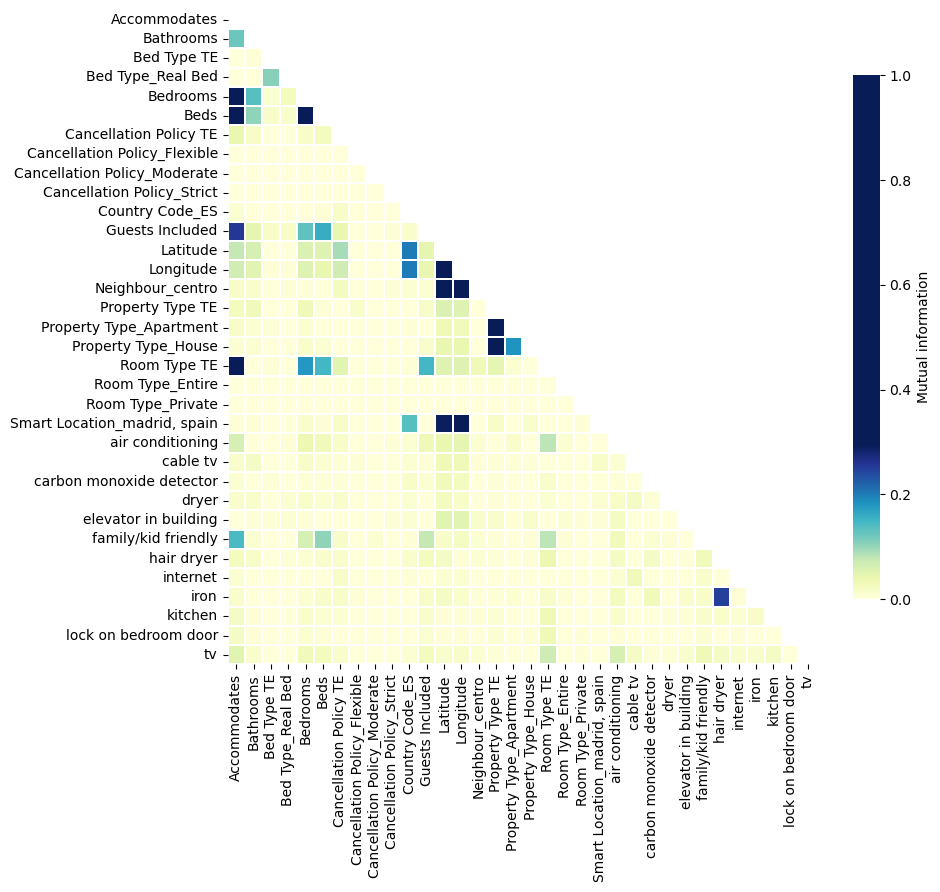

In [59]:
#| output: True
#| label: fig-matrix-mi
#| fig-cap: "Mutual information matrix"
df_scores = pd.DataFrame(scores).sort_values(['feature1','feature2'])
df_scores_heatmap = df_scores.pivot(index = 'feature1', columns = 'feature2', values = 'score')
heatmap_01_plot(df_scores_heatmap, triangle = True, threshold = 0.3, label = "Mutual information")

In [60]:
features_to_remove = ['Beds','Bedrooms', 'Room Type TE', 'Room Type_Entire', 'Room Type_Private', 'Smart Location_madrid, spain',
                      'Neighbour_centro', 'Country Code_ES', 'Property Type_Apartment', 'Property Type_House', 'Bed Type TE',
                      'Cancellation Policy_Flexible', 'Cancellation Policy_Moderate', 'Cancellation Policy_Strict']
df_train_sel = df_train_enc3.drop(features_to_remove, axis = 1)

#### Optimal subset of features.

From this set of twenty features, an optimal subset was searched using a genetic algorithm combined with a lineal regression model to evaluate the candidate subsets. After running the genetic algorithm, a subset of fifteen features was selected.

In [61]:
#  Optimal subset of features

# Define features
X = df_train_sel
y = df_train_imp['Price']
all_feature_names = X.columns

# Use a simple Linear Regression model as the base estimator
estimator = LinearRegression()

# Configure the Genetic Algorithm
evolved_selector = GAFeatureSelectionCV(
    estimator=estimator,
    cv=5,
    scoring='neg_root_mean_squared_error',         # Metric to maximize (the fitness function)
    population_size=20,         # Number of individuals (feature subsets) in each generation
    generations=10,             # Number of times the GA will iterate
    crossover_probability=0.8,        # Probability of combining two parents
    mutation_probability=0.1,         # Probability of flipping a feature bit (0->1 or 1->0)
    n_jobs=-1,                  # Use all available CPU cores for evaluation
    verbose=True,             
    keep_top_k=3,               # Keep the top 3 individuals from generation to generation (elitism)
)

# --- Run the Optimization ---
# The .fit() method runs the full Genetic Algorithm process
print("\n--- Starting GA Feature Selection (This may take a minute) ---")
evolved_selector.fit(X, y) 
print("--- GA Feature Selection Complete ---")

# Get the mask of the best features found
best_feature_mask = evolved_selector.support_
# Get the indices of the selected features
selected_indices = np.where(best_feature_mask)[0] 
# Get the names of the selected features
selected_features = [all_feature_names[i] for i in selected_indices]

print("\n## 🏆 Best Features Found")
print(f"Number of features selected: {len(selected_indices)}")
print(f"Selected features: {selected_features}")


--- Starting GA Feature Selection (This may take a minute) ---
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	-63.3074	3.68098    	-59.8049   	-70.3464   
1  	38    	-60.4575	0.798063   	-59.8049   	-62.5595   
2  	37    	-59.949 	0.180374   	-59.8049   	-60.6352   
3  	33    	-59.7715	0.0771105  	-59.5738   	-59.8662   
4  	39    	-59.7079	0.0742089  	-59.5738   	-59.8616   
5  	33    	-59.6208	0.0774416  	-59.4745   	-59.6934   
6  	38    	-59.5654	0.0890895  	-59.4131   	-59.6934   
7  	33    	-59.4885	0.0517162  	-59.4131   	-59.5988   
8  	33    	-59.4444	0.0244279  	-59.4131   	-59.4745   
9  	37    	-59.4264	0.0202952  	-59.4089   	-59.4745   
10 	36    	-59.4082	0.0232869  	-59.369    	-59.4629   
--- GA Feature Selection Complete ---

## 🏆 Best Features Found
Number of features selected: 15
Selected features: ['Accommodates', 'Bathrooms', 'Property Type TE', 'Cancellation Policy TE', 'air conditioning', 'family/kid friendly', 'tv', 'carbon monoxide detecto

### Model performance

Three algorithms were tested to find the model with the highest predictive power: Random Forest, Gradient Boosting and Support Vector Machine. Hyperparameter tuning was performed using Optuna framework exploring each model's parameter space to identify optimal configurations that maximize predictive performance using TPE algorithm. Several scores were calculated but median absolute error was used to drive hyperparameter optimization. In the exploratory data analysis, some extreme price values were found (see @fig-price), so this metric was chosen because it is more robust to outliers.

Considering this metric, the model with the best performance was the Support Vector Machine with an RBF kernel. Additionally, this model showed the least overfitting.

In [62]:
#| output: asis

storage = 'sqlite:///optuna/optuna_ML_exercise.db'
list_results = ['train_medAE', 'test_medAE', 'test_rmse', 'test_r2'] 
list_studies = {'name_model': ['MML_randomforest_data1', 'MML_xgboost_data1', 'MML_SVR_RBF_data1'],
                'Model': ['Random Forest', 'XGBoost', 'SVR kernel RBF']}
df_studies = pd.DataFrame(list_studies)
results = best_trial_scores_ML(storage, list_results, list_studies['name_model'])
df = pd.DataFrame(results, columns = ['name_model', 'Train score', 'Valid score', 'RMSE', 'R2'])

df_final = df_studies.merge(df, on='name_model').drop(['name_model'], axis=1)

print(df_final.to_markdown(index=False))

| Model          |   Train score |   Valid score |   RMSE |    R2 |
|:---------------|--------------:|--------------:|-------:|------:|
| Random Forest  |        10.631 |        15.292 | 54.312 | 0.444 |
| XGBoost        |        12.3   |        15.343 | 55.977 | 0.409 |
| SVR kernel RBF |        13.394 |        13.806 | 61.057 | 0.3   |


### Final model

Based on the results above, a Support Vector Machine model was trained using 80% of the dataset, with validation performed on the remaining 20%. This model achieved a median absolute error of 13.78, consistent with the values obtained during the training process.

#### Prediction

The available data contained 17 samples missing price data. These samples were filtered and used to test the trained model (see **data_to_predict.csv** and **data_with_prediction.csv** files) 

In [63]:
df_for_prediction = airbnb_data[airbnb_data['Price'].isna()]
df_for_prediction.to_csv("./data/prediction_dataset.csv", index=False)
df_for_prediction.T

,1337,1512,1691,2906,2911,4524,5369,6410,9124,9251,10755,11445,11555,11867,13388,14164,14343
ID,3955511,13636816,16199273,3760176,820869,6549063,7173032,10495669,17084704,10715621,15793964,361488,2744574,1727101,1250842,6681279,14574259
Listing Url,https://www.airbnb.com/rooms/3955511,https://www.airbnb.com/rooms/13636816,https://www.airbnb.com/rooms/16199273,https://www.airbnb.com/rooms/3760176,https://www.airbnb.com/rooms/820869,https://www.airbnb.com/rooms/6549063,https://www.airbnb.com/rooms/7173032,https://www.airbnb.com/rooms/10495669,https://www.airbnb.com/rooms/17084704,https://www.airbnb.com/rooms/10715621,https://www.airbnb.com/rooms/15793964,https://www.airbnb.com/rooms/361488,https://www.airbnb.com/rooms/2744574,https://www.airbnb.com/rooms/1727101,https://www.airbnb.com/rooms/1250842,https://www.airbnb.com/rooms/6681279,https://www.airbnb.com/rooms/14574259
Scrape ID,20170315084710,20170615002708,20170407214119,20170615002708,20170615002708,20170315084710,20170615002708,20170407214119,20170404145355,20170407214119,20170403112154,20170407214119,20170407214119,20170407214119,20170407214119,20170407214119,20170407214119
Last Scraped,2017-03-15,2017-06-15,2017-04-08,2017-06-15,2017-06-15,2017-03-15,2017-06-15,2017-04-08,2017-04-05,2017-04-08,2017-04-04,2017-04-08,2017-04-08,2017-04-08,2017-04-08,2017-04-08,2017-04-08
Name,Es Talaiot,Central and new! Danish design,"Private Room in Rios Rosas, Madrid",87 m2 in the heart of Vesterbro,Beauty & charm in the heart of Cph.,Discover Port d'Andratx,Private sunny terrace next2 Kødbyen,Ático centrico y tranquilo / Atic,Au centre de Paris,Lujoso apartamento en Gran Vìa 48,GrandPrix Prime Position,RETIRO PARK2 CHALET INDUSTRIAL-CHIC,Mansion with royal garden,RETIRO PARK1 CHALET INDUSTRIAL-CHIC,Habitación Moncloa-AravacaArgüelles,Fantastico Piso Barrio de Salamanca,"LONGTERM welcome-New,Central,100m² for 1-6 Per..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cancellation Policy,moderate,strict,moderate,moderate,moderate,strict,moderate,flexible,flexible,strict,moderate,strict,flexible,flexible,flexible,strict,flexible
Calculated host listings count,3.0,1.0,1.0,1.0,1.0,10.0,1.0,1.0,1.0,8.0,1.0,12.0,1.0,12.0,1.0,1.0,1.0
Reviews per Month,NaN,5.37,NaN,0.14,0.64,NaN,0.69,2.79,0.52,0.29,0.83,NaN,NaN,NaN,NaN,NaN,0.27
Geolocation,"39.5960565717,2.92568968608","55.6771862556,12.5736124985","40.4412509377,-3.6976986412","55.6703787963,12.556125886","55.6845581553,12.5697019142","39.5394732535,2.38109746085","55.6675641504,12.5572520646","40.4213739962,-3.71062874346","48.8555190702,2.36024146521","40.4216172834,-3.70531022971","-37.8425217645,144.954776562","40.4090842507,-3.67313074595","40.4235053294,-3.68926064745","40.4101938251,-3.67179469843","40.4309394385,-3.72179915763","40.4344672535,-3.68226239684","40.4090062047,-3.71006935185"
